# 장애인 이용 차량 전용 주차구역에 불법 주차하는 일반 이용 차량 단속 코드

# 장애인 차량 전용 주차구역에 불법 주차한 차량의 DB를 illegal table을 만들어서 저장하기
* 자신이 가지고 있는 db(입차시 정보를 저장할 database)에 illegal이라는 table을 만든다.(코드 실행시 자동 생성)
* 입차 정보에서 장애인 이용 차량이 아니라고 저장 되어 있는 차 번호는 illegal table에 db를 저장한다.
* 주의할 점: 불법 주차를 테스트 해보려고할 때, 입차 정보 db 테이블에 해당 차량의 last_num이 저장되어 있어야 한다.

# library

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
import numpy as np
import easyocr

import utils_test

import pandas as pd
import pymysql

c:\Python3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Webcam

In [2]:
utils_test.webcam(0,'yellow_image')

# Yolo & OCR

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


클래스 번호:  0 
클래스: norm 
norm일 확률:  0.9798038005828857


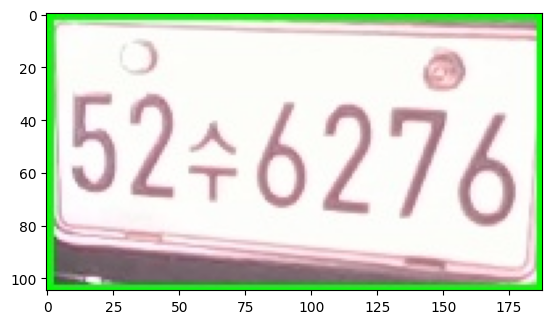

In [3]:

img_path = './image/yellow_image/img.png'

img = cv2.imread(img_path)

with open('obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('yolov4-tiny-custom.cfg', 'yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

try : 
    classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

    clss = classIds.tolist()
    score = scores.tolist()

    reader = easyocr.Reader(['ko'])

    # # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

    for i in range(len(clss)):
        box = boxes[i].tolist()
        w = box[0]
        h = box[1]
        x = box[2]
        y = box[3]
        bbox = img[h:y+h, w:x+w]


        if clss[i] == 0 or clss[i] == 1:
            print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])

            # 22.11.05  옮김 ㅎㅅㅇ
            class_num = str(clss[i])

            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            cv2.imwrite('./image/yellow_image/bbox.jpg', bbox) #저장
            bbox = Image.open('./image/yellow_image/bbox.jpg')

            if bbox is None:
                print('Image load failed!')
                bbox.exit()
            
            bbox_norm = Image.open("./image/yellow_image/bbox.jpg")
            plt.imshow(bbox_norm)
            result = reader.readtext(bbox_norm)
            
            if len(result[0][1]) <= 2:
                src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
                dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
                cv2.imwrite('./image/yellow_image/bbox_black.jpg', dst1)
                bbox_black = Image.open('./image/yellow_image/bbox_black.jpg')
                result = reader.readtext(bbox_black)
            
                if len(result) ==0:
                    bbox_re = bbox.resize((int(bbox.width*2), int(bbox.height)))         
                    bbox_re.save('./image/yellow_image/bbox_re.jpg')
                    bbox_re = cv2.imread('./image/yellow_image/bbox_re.jpg')
                    src_hsv = cv2.cvtColor(bbox_re, cv2.COLOR_BGR2HSV)
                    dst1 = cv2.inRange(bbox_re, (0, 0, 0), (120, 120, 120))
                    cv2.imwrite('./image/yellow_image/bbox_re_black.jpg', dst1)
                    bbox_re_black = Image.open('./image/yellow_image/bbox_re_black.jpg')
                    result = reader.readtext(bbox_re_black)
                    plt.imshow(bbox_re_black)
                 
            for a in result:
                re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ',''))

    # -- 이미지 에러가 나면 출력할 구문
except :
  print('====IMG_ERR====')

# 문자 추출

In [4]:
first_num , second_num = utils_test.result_plate(result)
print('차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)

차량번호 앞자리:  52수 
차량번호 뒷자리:  6276


# 불법 주차 차량 DB에 저장
## illegal_info : 불법 주차 차량을 저장하는 테이블

In [46]:

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8') # 여기서 db는 자신이 입차 정보를 넣어놨던 database 이름을 넣어준다
    
# Dict형식의 CURSOR  
cur = conn.cursor(pymysql.cursors.DictCursor)

# SQL 작성 
sql_in = "select * from total_info"

# SQL 실행
cur.execute(query=sql_in)

# 결과 가져오기
result_in = cur.fetchall()

df_in = pd.DataFrame(result_in)
find = df_in[df_in['last_number'] == second_num]

if find['person_type'].values[0] == '1':
    pass
else:
    conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8')
    cur = conn.cursor()
    #아랫줄은 제일 처음에 table 생성 시에만 사용함
    #cur.execute("create table illegal_info (last_num char(4), first_num char(4))") # 처음 한 번만 실행해야한다. illegal이라는 이름의 테이블을 db_test라는 데이터 베이스 아래에 만드는 코드(아예 따로 빼서 먼저 실행시켜두고 이 코드에서 없애는 것도 방법일듯)
    cur.execute(f"insert into illegal_info values(\"{second_num}\", \"{first_num}\")")
    conn.commit()
